In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn import feature_selection as fs
from sklearn import preprocessing as pp
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from boruta import BorutaPy

In [33]:
def read_and_get_data():
    train_data = pd.read_csv('./training.csv')
    test_data = pd.read_csv('./testing.csv')
    train_data = split_datetime(train_data)
    test_data = split_datetime(test_data)
    
    x_train = catogirical_to_numerical(train_data.drop(['Appliances'], axis = 1))
    y_train = train_data['Appliances'].values

    x_test = catogirical_to_numerical(test_data.drop(['Appliances'], axis = 1))
    y_test = test_data['Appliances'].values
    return x_train, y_train, x_test, y_test

def low_variance_selector(var_per):
    return fs.VarianceThreshold(threshold=(var_per*(1-var_per)))

def univariant_selector(univariant_per):
    return fs.SelectPercentile(fs.mutual_info_regression, percentile=univariant_per)

def RFE_selector(num):
    return fs.RFE(estimator=LinearRegression(), n_features_to_select=num, step = 1)

def boruta_selector():
    return BorutaPy(RandomForestRegressor(max_depth=100,n_estimators=10), verbose=2, random_state=1)

In [14]:
def catogirical_to_numerical(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = df[col].astype('category')
    vec = DictVectorizer(sparse=False, dtype=int)
    dc = df.to_dict('records')
    result = vec.fit_transform(dc)
    return result
def split_datetime(df):
    df['date'] = pd.to_datetime(df['date'])
    year = list()
    month = list()
    day = list()
    hour=list()
    for i in np.arange(df.count()[0]):
        year.append(df['date'][i].year)
        month.append(df['date'][i].month)
        day.append(df['date'][i].day)
        hour.append(df['date'][i].hour)
    df['year'] = year
    df['month'] = month
    df['day'] = day
    df['hour'] = hour
    df = df.drop(['date'], axis = 1)
    return df

In [35]:
def gen_linear_pipeline(vp, up, num, degree=2):
    return make_pipeline(low_variance_selector(vp),
                         univariant_selector(up),
                         RFE_selector(num),
                         pp.PolynomialFeatures(degree),
                         LinearRegression()
                        )

def gen_rf_pipeline(vp, up, num, md, ne, degree=2):
    return make_pipeline(low_variance_selector(vp),
                         univariant_selector(up),
                         RFE_selector(num),
                         pp.PolynomialFeatures(degree),
                         RandomForestRegressor(max_depth=md, n_estimators=ne)
                        )

def gen_nn_pipeline(vp, up, num, hls, al=0.0001, degree=2):
    return make_pipeline(low_variance_selector(vp),
                         univariant_selector(up),
                         RFE_selector(num),
                         pp.MinMaxScaler(copy=False, feature_range=(-1,1)),
                         pp.PolynomialFeatures(degree),
                         MLPRegressor(hidden_layer_sizes=hls, alpha=al)
                        )

In [12]:
def test_regressor(x_train,x_test,y_train,y_test,degree):    
    x_transform = low_variance_selector(0.8).fit_transform(x_train, y_train)
    x_transform = univariant_selector(90).fit_transform(x_transform, y_train)
    x_transform = RFE_selector(15).fit_transform(x_transform, y_train)
    x_transform = pp.PolynomialFeatures(degree).fit_transform(x_transform, y_train)
    rf = RandomForestRegressor(max_depth=100)
    rf.fit(x_transform,y_train)

    test_transform = low_variance_selector(0.8).fit_transform(x_test, y_test)
    test_transform = univariant_selector(90).fit_transform(test_transform, y_test)
    test_transform = RFE_selector(15).fit_transform(test_transform, y_test)
    test_transform = pp.PolynomialFeatures(degree).fit_transform(test_transform, y_test)
    y_pred = rf.predict(test_transform)
    return y_pred

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cal_errors(y_test,y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rms = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print('MAE = {}, RMS = {}, R2 = {}, MAPE = {}'.format(mae,rms,r2,mape))

def draw_plot(y_test,y_pred):
    plt.figure(figsize=(10,10))
    plt.plot(np.arange(len(y_pred)), np.sort(y_pred), color='blue', linewidth=1)

    plt.plot(np.arange(len(y_test)), np.sort(y_test), color='red', linewidth=1)

    plt.xticks(())
    plt.yticks(())

    plt.show()

##### Test pipelines

In [17]:
x_train, y_train, x_test, y_test = read_and_get_data()
linear = gen_linear_pipeline(0.8,90,15)
linear = linear.fit(x_train,y_train)
y_pred = linear.predict(x_test)
cal_errors(y_test,y_pred)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


MAE = 50.73260562560525, RMS = 8057.8473546327, R2 = 0.21945278623523745, MAPE = 58.36786846540427


In [41]:
x_train, y_train, x_test, y_test = read_and_get_data()
rf = gen_rf_pipeline(0.8,90,15,100,50,degree=2)
rf = rf.fit(x_train,y_train)
y_pred = rf.predict(x_train)
cal_errors(y_train,y_pred)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


MAE = 15.703291533641025, RMS = 1071.2079156942025, R2 = 0.8986835015681673, MAPE = 16.53552945166256


In [39]:
x_train, y_train, x_test, y_test = read_and_get_data()
nn = gen_nn_pipeline(0.8,90,15,15,degree=3)
nn = nn.fit(x_train,y_train)
y_pred = nn.predict(x_test)
cal_errors(y_test,y_pred)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MAE = 47.79098655308418, RMS = 7822.750439173369, R2 = 0.24222614421166633, MAPE = 52.84578187035061


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### 3. Cross Validation

In [49]:
degrees = {0,1,2,3,4,5,6,7,8,9,10}
results = list()
for degree in degrees:
    x_train, y_train, x_test, y_test = read_and_get_data()
    y_pred = test_regressor(x_train,x_test,y_train,y_test,degree)
    print('testing for degree :{}'.format(degree))
    cal_errors(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results.append(mape)
print(results)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


testing for degree :0
MAE = 59.89923687681072, RMS = 10326.298749785343, R2 = -0.00028746672812918206, MAPE = 76.50256156358569


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


testing for degree :1
MAE = 82.92247497506173, RMS = 16908.8056173879, R2 = -0.637921461139878, MAPE = 110.74593360304759


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


testing for degree :2
MAE = 82.28103803455353, RMS = 14349.960017925185, R2 = -0.3900513147829181, MAPE = 116.86077770053238


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


testing for degree :3
MAE = 76.8221239986586, RMS = 15792.97247164264, R2 = -0.5298329835842572, MAPE = 96.85226690038988


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


testing for degree :4
MAE = 114.65078556800101, RMS = 24324.94486228535, R2 = -1.3563077211089434, MAPE = 191.08375488594754


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


testing for degree :5
MAE = 88.58717468398355, RMS = 17833.060201492935, R2 = -0.7274521147601312, MAPE = 121.91948902564167


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


testing for degree :6
MAE = 79.5772303325223, RMS = 15238.138114580515, R2 = -0.47608731275607785, MAPE = 111.20442282599356


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


testing for degree :7
MAE = 81.34774860169608, RMS = 15730.916749048576, R2 = -0.52382177249559, MAPE = 113.54530678097257


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


testing for degree :8
MAE = 120.20472358816865, RMS = 27224.874158479968, R2 = -1.637217948448773, MAPE = 201.2456993968417


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


testing for degree :9
MAE = 85.46744516156852, RMS = 15491.520377009754, R2 = -0.5006319349426529, MAPE = 118.89153208634764


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


testing for degree :10
MAE = 99.58375621148444, RMS = 19662.28156418486, R2 = -0.9046450516786102, MAPE = 142.27376148179872
[76.50256156358569, 110.74593360304759, 116.86077770053238, 96.85226690038988, 191.08375488594754, 121.91948902564167, 111.20442282599356, 113.54530678097257, 201.2456993968417, 118.89153208634764, 142.27376148179872]


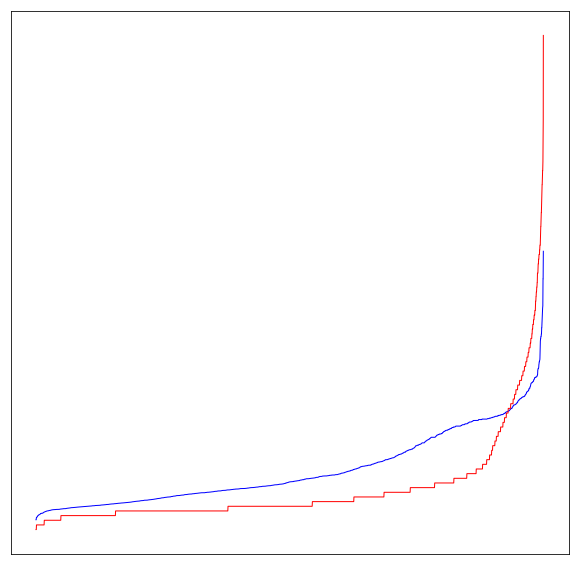

In [46]:
draw_plot(y_test,y_pred)

In [ ]:
degree = np.arange(0, 21)
train_score, val_score = validation_curve(gen_rf_pipeline(0.8,5,25,), x_train, y_train,
                                          'polynomialfeatures__degree', scoring='precision' degree, cv=5)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataCon

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

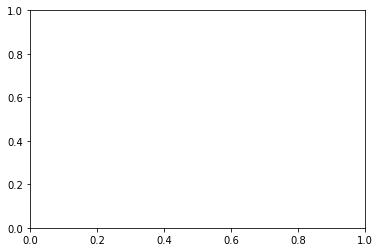

In [24]:
degree = np.arange(0, 5)
train_score, val_score = validation_curve(gen_rf_pipeline(vp=0.8,up=5,num=25,md=100,ne=50), x_train, y_train,
                                          'polynomialfeatures__degree', scoring = 'neg_mean_squared_log_error', param_range = degree, cv=5)

plt.plot(degree, np.mean(train_score), color='blue', label='training score')
plt.plot(degree, np.mean(val_score), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

In [ ]:
linear = gen_linear_pipeline(0.8,5,25,5)

In [ ]:
linear.fit(x_train,y_train)

In [ ]:
score_result = cross_val_score(linear, x_train, y_train, cv = 10)

In [ ]:
score_result

In [ ]:
y_pred = linear.predict(x_test)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(y_pred)), np.sort(y_pred), color='blue', linewidth=1)

plt.plot(np.arange(len(y_test)), np.sort(y_test), color='red', linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

In [26]:
train_score

array([[-0.4455847 , -0.49648468, -0.5089872 , -0.51593544, -0.53461298],
       [-0.07668387, -0.11319209, -0.19030986, -0.20551818, -0.20115378],
       [-0.07699538, -0.19095743, -0.19068515, -0.20410933, -0.16965274],
       [-0.07193173, -0.19105676, -0.17734893, -0.20451922, -0.15671733],
       [-0.07691828, -0.20273384, -0.11879595, -0.20539741, -0.17002988]])

In [25]:
val_score

array([[-0.73105621, -0.50631178, -0.47638451, -0.42261478, -0.36698663],
       [-1.28702756, -0.81288374, -0.62239932, -0.52190358, -1.10930242],
       [-1.21373564, -0.83299045, -0.60996494, -0.48342929, -1.0291079 ],
       [-1.09850289, -0.84621622, -0.52838626, -0.48568639, -1.21644962],
       [-1.13218931, -0.74402887, -0.62072101, -0.47657611, -0.92691371]])

In [15]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [21]:
degree = np.arange(2, 5)

In [22]:
degree

array([2, 3, 4])